In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.layers import Dropout,Dense,LSTM,GRU,Conv2D,Activation,BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
import joblib
import os
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.models import load_model
import matplotlib.dates as mdates
from time import time
import multiprocessing as mp
from tensorflow.keras import Model
import itertools
from functools import partial
import shap

## Set global parameters

In [3]:
# 指定训练使用的GPU
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# 设置全局控制的变量 set global parameters
freq = 'D'
region = 'NA'
model_sty = 'gru'

if freq == 'H':
    data_num = 17520
    list_col = ['NO2+h','NO2-h','NO2-2h','NO2-3h']
    col_name  = list_col[0] + '_' + model_sty
    file_name = 'pol_mete_' + region + '_' + freq + '.csv'
    file_name_pre = 'pol_mete_' + region + '_' + freq + '_predict.csv'
if freq == '3H':
    data_num = 5840
    list_col = ['NO2+3h','NO2-3h','NO2-6h','NO2-9h']
    col_name  = list_col[0] + '_' + model_sty
    file_name = 'pol_mete_' + region + '_' + freq + '.csv'
    file_name_pre = 'pol_mete_' + region + '_' + freq + '_predict.csv'
if freq == 'D':
    data_num = 730
    list_col = ['NO2+d','NO2-d','NO2-2d','NO2-3d']
    col_name  = list_col[0] + '_' + model_sty
    file_name = 'pol_mete_' + region + '_' + freq + '.csv'
    file_name_pre = 'pol_mete_' + region + '_' + freq + '_predict.csv'

file_path = 'data/'
file_path_model = ''

In [4]:
# 模型训练函数，增加了早停和指数衰减学习率 define functions of training model
def model_train(xtrain,ytrain,xtest,ytest,model,is_callback=False,is_earlystop=False,is_lrdecay=True
                ,batch_size=512,epochs=50,lr_start=0.001,lr_end=0.00001,save_name='model_gru',step_decay=5000):

    # 配置回调函数：断点续训，早停和衰减学习率
    callbacks = []
    if is_earlystop:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,verbose=1
                                                       ,restore_best_weights=True,mode='auto')
        callbacks.append(es_callback)
    lr_start = lr_start
    lr_end = lr_end
    if is_lrdecay:
        # 使用callback搭建学习率框架
        def lr_scheduler(epoch):
            lr_decay = (lr_start-lr_end)/step_decay
            return lr_start - lr_decay*epoch
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose=1)
        callbacks.append(lr_callback)

    if is_callback:
        checkpoint_save_path = file_path_model + "checkpoint/" + save_name + ".ckpt"
        if os.path.exists(checkpoint_save_path + '.index'):
            print('-------------load the model-----------------')
            model.load_weights(checkpoint_save_path)

        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor='val_loss')
        callbacks.append(cp_callback)

    history = model.fit(xtrain,ytrain,batch_size=batch_size,epochs=epochs
                        ,validation_data=(xtest,ytest)
                        ,validation_freq=1
                        # ,validation_split=0.05
                        ,callbacks=callbacks
                        )

    model.summary()
    # 子类模型直接保存存在错误，最好保存权重，然后加载模型
    #filename = file_path_model + 'model/' + save_name
    #model.save(filename, save_format='tf')
    return model,history

In [5]:
# define functions of evaluation
def model_evaluation(model,history,xtest,ytest,is_history=True):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    if is_history:
        # 读取loss值，绘制损失曲线  load loss  values
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(loss,label='Training Loss')
        plt.plot(val_loss,label='Validation Loss')
        plt.legend()
        plt.show

    # 测试及输入模型进行测试 predicting
    pre_ytest_ = model.predict(xtest)
    # 将预测数据反归一化,因只需反归一化标签，不能直接使用std.inverse_transform（）
    # 提取归一化化的均值std.mean_和方差var_，使用公式反归一化
    # 预测值
    pre_ytest = pre_ytest_ * np.sqrt(std_no2) + std_mean
    pre_ytest = pre_ytest.reshape((pre_ytest.shape[0],))
    # 真实值
    rea_ytest = ytest * np.sqrt(std_no2) + std_mean
    # 画出真实值和预测值的对比曲线  plotting
    plt.subplot(122)
    plt.plot(rea_ytest[:60],color='red',label='NO2 real values')
    plt.plot(pre_ytest[:60],color='blue',label='NO2 predicted values')
    plt.legend()
    # plt.savefig(file_path_model + 'chart/loss_curves_cv_ '+ str(i) + '.png', dpi=500)
    plt.show()

    # 模型评价指标 computing evaluation metrics
    mse = mean_squared_error(rea_ytest, pre_ytest)
    rmse = sqrt(mse)
    mae = mean_absolute_error(rea_ytest, pre_ytest)
    r2 = r2_score(rea_ytest, pre_ytest)
    print('均方误差：%.6f' % mse, '\n均方根误差：%.6f' % rmse, '\n平均绝对误差：%.6f' % mae, '\nR2：%.6f' % r2)
    return rmse, mae, r2

## Load data

In [6]:
# load data with tem time-steps
data1 = np.load(file_path + 'numpy/NA_d_array_14.npz',allow_pickle=True)
xtrain,ytrain,xtest,ytest,ytrain_,ytest_ = data1['a'],data1['b'],data1['c'],data1['d'],data1['e'],data1['f']

In [7]:
xtrain, xtest = xtrain[:,-10:,:], xtest[:,-10:,:]

In [8]:
xtrain.shape

(2126158, 10, 36)

In [7]:
# 提取归一化化的均值std.mean_和方差var_，使用公式反归一化  load normalization parameters
std = pd.read_csv(file_path + 'normalization_params/normalization_params_D_no2-idx-0')
std_no2 = std['std'][0]
std_mean = std['mean'][0]

## GRU-R model

In [8]:
# Define construction of GRU-R model
# 搭建模型框架，并训练模型
# with residual connection
class GRU_R(Model):
    def __init__(self):
        super(GRU_R,self).__init__()

        self.r1 = GRU(32,activation='tanh',return_sequences=True)
        self.d1 = Dropout(0.1)
        self.r2 = GRU(32,activation='tanh',return_sequences=True)
        self.d2 = Dropout(0.1)
        self.r3 = GRU(64,activation='tanh',return_sequences=True)
        self.d3 = Dropout(0.1)
        self.r4 = GRU(64,activation='tanh',return_sequences=True)
        self.d4 = Dropout(0.1)
        self.r5 = GRU(96,activation='tanh',return_sequences=True)
        self.d5 = Dropout(0.1)
        self.r6 = GRU(96,activation='tanh',return_sequences=True)
        self.d6 = Dropout(0.1)
        self.r7 = GRU(16,activation='tanh')
        self.d7 = Dropout(0.1)

        self.re1 = GRU(96,'tanh',return_sequences=True)
        #self.re2 = GRU(192,'tanh',return_sequences=True)
        self.f1 = Dense(1)
        
    def call(self,inputs):
        

        x = self.r1(inputs)
        x = self.d1(x)
        residual = self.re1(x)
        x = self.r2(x)
        x = self.d2(x)
        

        x = self.r3(x)
        x = self.d3(x)
        x = self.r4(x)
        x = self.d4(x)


        x = self.r5(x)
        x = self.d5(x)
        x = self.r6(x+residual)
        x = self.d6(x)
        x = self.r7(x)
        x = self.d7(x)

        y = self.f1(x)
        return y

def define_model():
    model_GRU_R = GRU_R()

    # 配置模型训练方法,loss:损失函数，optimizer：优化器，metrics：评价指标
    optimizer=tf.keras.optimizers.Adam(0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
    model_GRU_R.compile(loss='mean_squared_error' ,optimizer=optimizer)
    
    return model_GRU_R

model_GRU_R = define_model()

## Training

### cross validation

In [ ]:
from sklearn.model_selection import KFold

Training = False
kfold = KFold(n_splits=5, shuffle=False)

# cross_validation
results_cv = []
preds_list = []
for i, j in enumerate(kfold.split(xtrain, ytrain)):
    idx_train, idx_test = j[0], j[1]
    # define model
    model_GRU_R = define_model()
    if Training :
    # training
        model,history = model_train(xtrain[idx_train],ytrain[idx_train],xtrain[idx_test],ytrain[idx_test] ,model_GRU_R,is_callback=True,is_earlystop=True,is_lrdecay=True
                            ,batch_size=2560,epochs=500,step_decay=500,lr_start=0.0001,lr_end=0.00001,save_name='model_GRU_R_cv_' + str(i))
        # evaluation
        # 加载训练好的模型， load pre-training model
        checkpoint_save_path = file_path_model + "checkpoint/model_GRU_R_cv_" + str(i) + ".ckpt"
        model_ = model_GRU_R
        model_.load_weights(checkpoint_save_path)
        # 对模型结果进行评价 evaluation
        results_metric = model_evaluation(model_, history, xtrain[idx_test], ytrain[idx_test])
        results_cv.append(results_metric)
    else:
        # 加载训练好的模型， load pre-training model
        checkpoint_save_path = file_path_model + "checkpoint/model_GRU_R_cv_" + str(i) + ".ckpt"
        print('Loading model from:', checkpoint_save_path)
        model_ = model_GRU_R
        model_.load_weights(checkpoint_save_path)

        preds_te = model_.predict(xtrain[idx_test], batch_size =25600)
        preds = np.concatenate([ytrain[idx_test].reshape(-1,1), preds_te.reshape(-1, 1), ytrain_[idx_test]], axis=1)
        preds_list.append(preds)

np.savez(file_path + 'cross_validation/NA_' + freq + '_predictions_' + model_sty + '.npz', cv0 = preds_list[0], cv01 = preds_list[1], cv02 = preds_list[2], cv3 = preds_list[3], cv4 = preds_list[4])       

In [16]:
results_cv

[(7.595100056858053, 5.465327285608616, 0.8449152905687876),
 (7.592777364650288, 5.477200016904067, 0.8446353870251246),
 (7.702808086901796, 5.450555057980747, 0.8417075714005905),
 (7.578052541193691, 5.486992118858299, 0.8453710791145814),
 (7.579378023145158, 5.471966797931036, 0.8462315163357575)]

### Training model in train sets

In [ ]:
model,history = model_train(xtrain,ytrain,xtest,ytest,model_GRU_R,is_callback=False,is_earlystop=True,is_lrdecay=True
                            ,batch_size=2560,epochs=500,step_decay=500,lr_start=0.0001,lr_end=0.00001,save_name='model_GRU_R')

In [26]:
# 加载训练好的模型， load model
checkpoint_save_path = file_path_model + "checkpoint/model_GRU_R.ckpt"
model_ = model_GRU_R
model_.load_weights(checkpoint_save_path) 

In [ ]:
# 对模型结果进行评价 evaluation
model_evaluation(model_, None, xtest, ytest, is_history=False)

## SHAP values

In [10]:
np.random.seed(100)
background = xtrain[np.random.choice(xtrain.shape[0], 1000, replace=False)]
np.random.seed(100)
X = xtrain[np.random.choice(xtrain.shape[0], 500000, replace=False)]

In [28]:
# shap values
explainer = shap.DeepExplainer(model_, background)

In [ ]:
shap_values = explainer.shap_values(X)

In [ ]:
shap_values[0].shape

In [ ]:
# 存储 save shap_value
np.save(file_path + 'shap_values/' + model_sty + '_shap_values_' + freq, shap_values[0])
np.save(file_path + 'shap_values/' + model_sty + '_expected_value_' + freq, explainer.expected_value)

In [24]:
# 加载计算好的 load shap_value
shap_values = np.load(file_path + 'shap_values/' + model_sty + '_shap_values_' + freq + '.npy')
# expected_value = np.load(file_path + 'shap_values/' + model_sty + '_expected_value_' + freq + '.npy')
# load features name
cols = pd.read_csv(file_path + 'features_name/features_name_' + freq)
cols = cols["0"].to_list()

In [25]:
shap_values.shape

(500000, 10, 36)

In [27]:
shap.initjs()
# 时间步长索引0，1，2，3分别表示三天前，两天前，一天前和当前时间，标签为未来一个时间步长的
shap.force_plot(explainer.expected_value, shap_values[0][-1], xtest[0][-1], feature_names=cols)

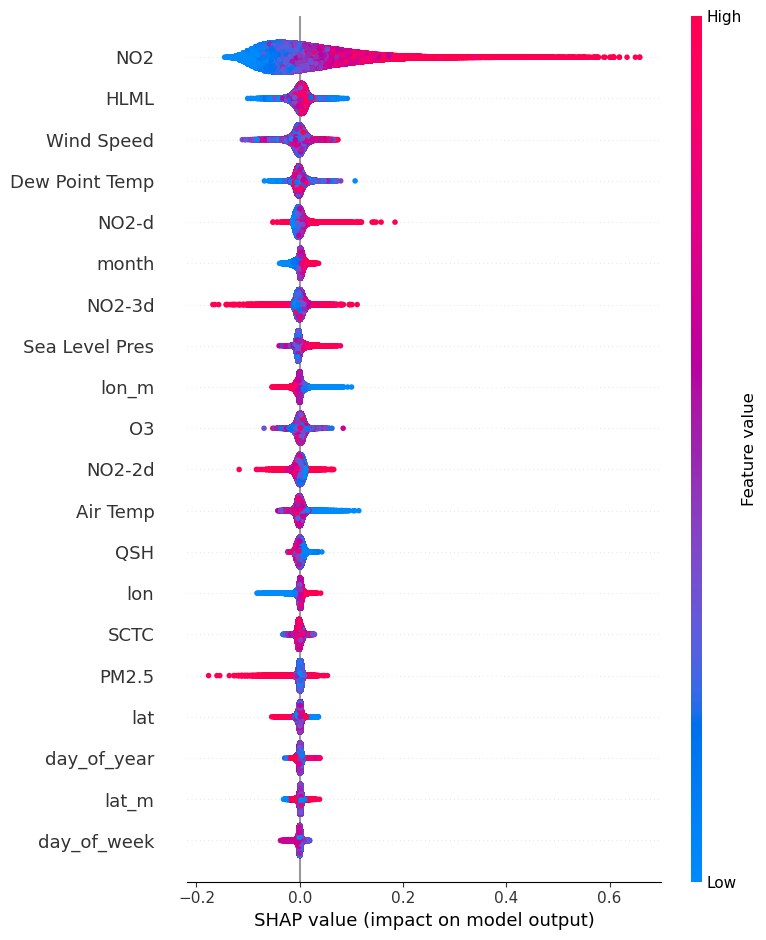

In [29]:
shap.summary_plot(np.mean(shap_values, axis=1), np.mean(X, axis=1), feature_names=cols)

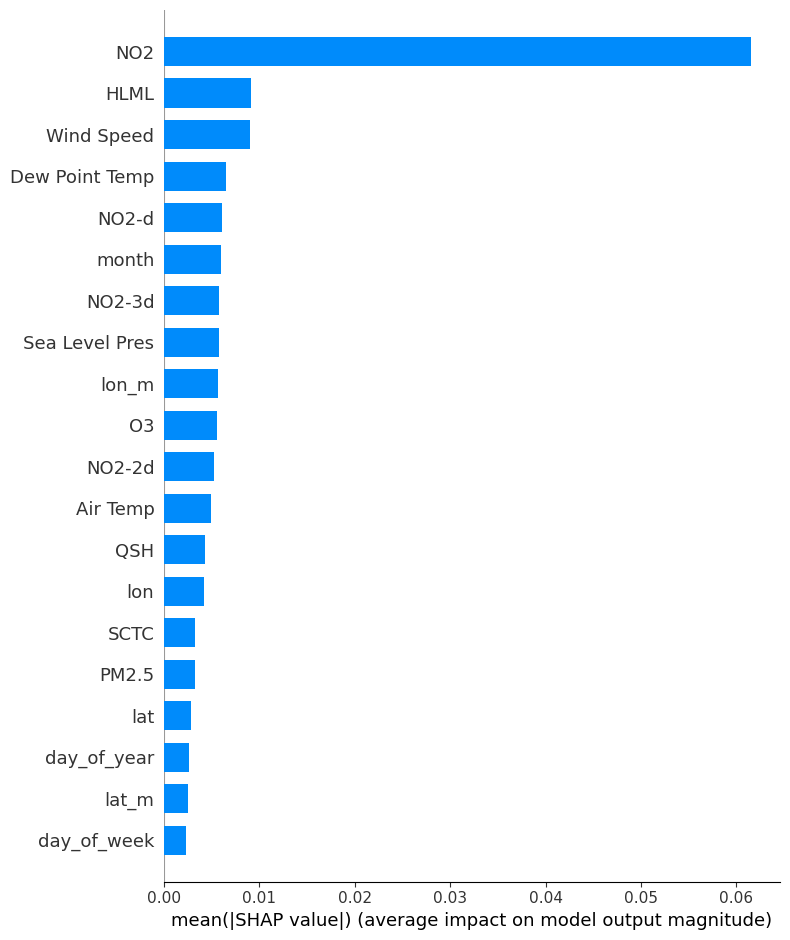

In [30]:
shap.summary_plot(np.mean(shap_values, axis=1), np.mean(X, axis=1), feature_names=cols, plot_type='bar')

## Evaluation

In [ ]:
# 对整体数据集进行预测  Predictions
real_train = ytrain * np.sqrt(std_no2) + std_mean
pre_train = model_.predict(xtrain)
pre_train = pre_train * np.sqrt(std_no2) + std_mean

real_test = ytest * np.sqrt(std_no2) + std_mean
pre_test = model_.predict(xtest)
pre_test = pre_test * np.sqrt(std_no2) + std_mean

In [14]:
# 评价模型性能 Evaluation
# 训练集 Training dataset
mse = mean_squared_error(pre_train,real_train)
rmse = sqrt(mse)
mae = mean_absolute_error(pre_train,real_train)
r2 = r2_score(pre_train,real_train)
print('模型在训练集性能：','均方误差：%.6f' % mse, '均方根误差：%.6f' % rmse, '平均绝对误差：%.6f' % mae, 'R2：%.6f' % r2)
# 测试集 Testing dataset
val_mse = mean_squared_error(pre_test,real_test)
val_rmse = sqrt(val_mse)
val_mae = mean_absolute_error(pre_test,real_test)
val_r2 = r2_score(pre_test,real_test)
print('模型在测试集性能：','均方误差：%.6f' % val_mse, '均方根误差：%.6f' % val_rmse, '平均绝对误差：%.6f' % val_mae, 'R2：%.6f' % val_r2)

模型在训练集性能： 均方误差：79.177554 均方根误差：8.898177 平均绝对误差：6.330835 R2：0.725877
模型在测试集性能： 均方误差：55.957355 均方根误差：7.480465 平均绝对误差：5.343275 R2：0.696913


## Predictions

In [31]:
# 将预测数据和真实值匹配，并添加时间索引和站点名: merge data and index
test_res = pd.concat([pd.DataFrame(real_test,columns=[list_col[0]]),pd.DataFrame(pre_test,columns=[col_name])
                         ,pd.DataFrame(ytest_[:,1:],columns=['index','station'])],axis=1)
train_res = pd.concat([pd.DataFrame(real_train,columns=[list_col[0]]),pd.DataFrame(pre_train,columns=[col_name])
                          ,pd.DataFrame(ytrain_[:,1:],columns=['index','station'])],axis=1)
data_res = pd.concat([train_res,test_res],axis=0)
data_res['index'] = (pd.to_datetime(data_res['index']) + pd.Timedelta('-1 days')).astype(str)

In [33]:
data_ = pd.read_csv(file_path + file_name_pre)

In [38]:

data_ = data_.drop(columns=col_name)

In [40]:
data_pre = pd.merge(data_, data_res.drop(columns=list_col[0]), how='left', on=['index','station'])

In [42]:
# 将预测值写入数据库 Saving predictions
data_pre.to_csv(file_path + file_name_pre, index=False)